# ESS 330 Final Project: Emissions in the Top CO₂ Polluting Countries

Before and After COVID-19

Yazeed Aljohani (Colorado State University)  
Josh Puyear (Colorado State University)  
Cade Vanek (Colorado State University)  
April 24, 2025

This project investigates trends in per capita greenhouse gas (GHG) emissions from the five largest CO2-polluting countries before, during, and after the COVID-19 pandemic. Using `ghg_excluding_lucf_per_capita` as the main variable, we analyze patterns in emissions and identify key predictors across sectors (e.g., manufacturing, transport). The study applies workflow modeling and ANOVA to examine emission changes and variation across countries. Results will inform strategies to reduce emissions and guide sustainable policy efforts.

# Introduction, Background, and Motivation

Climate change remains one of the most urgent global challenges, driven in large part by human greenhouse gas emissions. Among these, carbon dioxide is the most significant. Carbon dioxide is released through many activities such as burning fossil fuels, industrial production, and land-use practices. Even though international efforts like the Paris Agreement have pushed countries to reduce emissions, many continue to show increasing trends. A small group of countries contributes the most emissions globally, both in total and per person. These major contributors include countries like China, the United States, and India ([Friedlingstein et al., 2019](#ref-friedlingstein2019global)).

This project focuses on the five largest carbon dioxide polluting countries: China, the United States, India, Russia, and Japan. These countries are responsible for a significant share of global emissions and reflect a range of economic systems, energy sources, and industrial structures. To allow meaningful comparisons, we center our analysis on greenhouse gas emissions per person, using the variable ghg_excluding_lucf_per_capita. This variable removes land-use change from the emissions total, isolating emissions from industrial activity and fossil fuel use. By using this approach, we can better understand how much pollution is tied to each person’s activity and consumption within each country.

The COVID-19 pandemic created a global disruption that affected travel, trade, and production. Lockdowns and other restrictions slowed down factories, reduced transportation, and caused shifts in energy use. As a result, global carbon dioxide emissions in 2020 dropped by approximately 5.4 percent, marking the largest single-year decrease in history ([Forster et al., 2020](#ref-forster2020current)). This sudden drop was mostly due to temporary changes. As countries began reopening in 2021 and 2022, emissions started climbing again.

Our goal is to analyze how emissions changed in these five countries before, during, and after the pandemic. We look at three main periods: before COVID from 2015 to 2019, the year COVID began in 2020, and the early recovery years from 2021 to 2022. By studying per person emissions during these periods, we can see whether there were real shifts in emissions behavior and whether those shifts continued into recovery. We also want to understand what kinds of emissions changed the most. For example, did transportation-related emissions drop more than industrial ones? Did countries with manufacturing-based economies recover differently than those with service-based ones?

To explore these questions, we use two main methods. First, we build a workflow model using the tidymodels package in R. This lets us see which emission sources are the strongest predictors of overall greenhouse gas output per person. For example, we compare emissions from coal, oil, gas, cement, and other industry sectors. We also include factors like population and economic output. By analyzing these predictors, we can understand which sources matter most in each country and how they are connected to changes over time. Second, we use ANOVA to test whether the changes in emissions across the three time periods are statistically meaningful. We run this analysis for each country and compare their patterns.

The reason for focusing on per person emissions is that total emissions alone do not tell the full story. Countries with large populations may seem like major polluters in total, but their emissions per person might be lower than smaller, high-emitting countries. A per person view also reflects differences in daily life, energy use, and infrastructure. This is important for climate policy, because it shows whether emissions are driven by large populations, high-intensity consumption, or both.

Our analysis helps link data analysis to climate solutions. By identifying what types of emissions dropped the most during the pandemic and which ones came back quickly, we can suggest where to focus efforts. If, for instance, oil-related emissions dropped during lockdowns but then returned quickly, that might show a need for deeper investment in alternative transportation options. If manufacturing emissions remained stable, that could show how industrial processes are harder to change without long-term plans and policies.

This project is also a chance to make emissions data more relatable. People often hear that emissions went down during the pandemic, but they may not know what caused the change or how long it lasted. By using clear visuals and country comparisons, we can help explain these trends to wider audiences. This is especially important as the world faces increasing climate-related disasters. Understanding emission trends can support smarter planning and better communication around sustainable transitions.

Lastly, we are motivated by a bigger question: what can we learn from this accidental global experiment? The pandemic gave the world a chance to see what happens when daily life suddenly changes. Some of those changes, like working from home or using less transportation, might become long-term habits. Others may disappear as economies reopen. By analyzing which emission reductions lasted and which faded, we can start to imagine more realistic and effective ways to slow down climate change.

Energy-related emissions are an important aspect of analyzing CO2 emission changes before and after COVID because demands for energy will continue. Depending on where the five selected countries obtain fuels for energy generation, energy use plays a role in predicting total CO2 emissions for each country and can present opportunities for reductions in emissions. CO2 emitted per kilowatt-hour can provide insight into how much CO2 can be attributed to energy use.

#### Research Question

How did per capita greenhouse gas emissions change before, during, and after COVID-19 in the five largest CO₂-polluting countries, and which sector-specific emissions are the strongest predictors of these changes?

Which variables best predict **per capita CO2 emissions** for the top five cumulative CO2 emitter countries during 2015-2022?

Which variables best predict **per unit energy CO2 emissions** for the top five cumulative CO2 emitter countries during 2015-2022?

#

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Rows: 50191 Columns: 79
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): country, iso_code
dbl (77): year, population, gdp, cement_co2, cement_co2_per_capita, co2, co2...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

# Data Exploration & Methods:

### Data Source

-   We used greenhouse gas emissions data from Our World in Data ([Samborska, 2025](#ref-owid-scaling-up-ai)), which compiles information from the Global Carbon Project and other sources.

-   Focused years: 2015–2022.

-   Countries: China, United States, India, Russia, and Japan (top 5 emitters).

### Data Cleaning

Filtered for years 2015–2022.

Selected countries with valid ISO codes and the top 5 CO₂-polluting countries.

Selected key variables: ghg_excluding_lucf_per_capita, coal_co2, oil_co2, gas_co2, cement_co2, and other_industry_co2.

Created a new variable period to group years into pre-COVID (2015–2019), during COVID (2020), and post-COVID (2021–2022).

### Data Exploration

-   Plotted per capita GHG emissions over time for each country.

-   Plotted sector-specific CO₂ emissions by country and year.

In [ ]:
data_filtered <- data |>
  filter(year >= 2015, year <= 2022) |>
  filter(!is.na(iso_code) & nchar(iso_code) == 3)

In [ ]:
# Getting top 5 CO2 emitting countries by total GHG (excluding land use)
top_emitters <- data_filtered |>
  group_by(country) |>
  summarise(total_ghg = sum(total_ghg_excluding_lucf, na.rm = TRUE)) |>
  arrange(desc(total_ghg)) |>
  slice_head(n = 5) |>
  pull(country)

# Filtering data to include only those countries and select relevant variables
df <- data_filtered |>
  filter(country %in% top_emitters) |>
  select(country, year, ghg_excluding_lucf_per_capita,
         coal_co2, gas_co2, oil_co2, cement_co2, other_industry_co2)
df <- df |> drop_na(ghg_excluding_lucf_per_capita)

In [ ]:
# Adding period category (pre, during, post COVID)
df <- df |>
  mutate(period = case_when(
    year <= 2019 ~ "pre_covid",
    year == 2020 ~ "during_covid",
    year >= 2021 ~ "post_covid"
  )) |>
  mutate(period = factor(period, levels = c("pre_covid", "during_covid", "post_covid")))

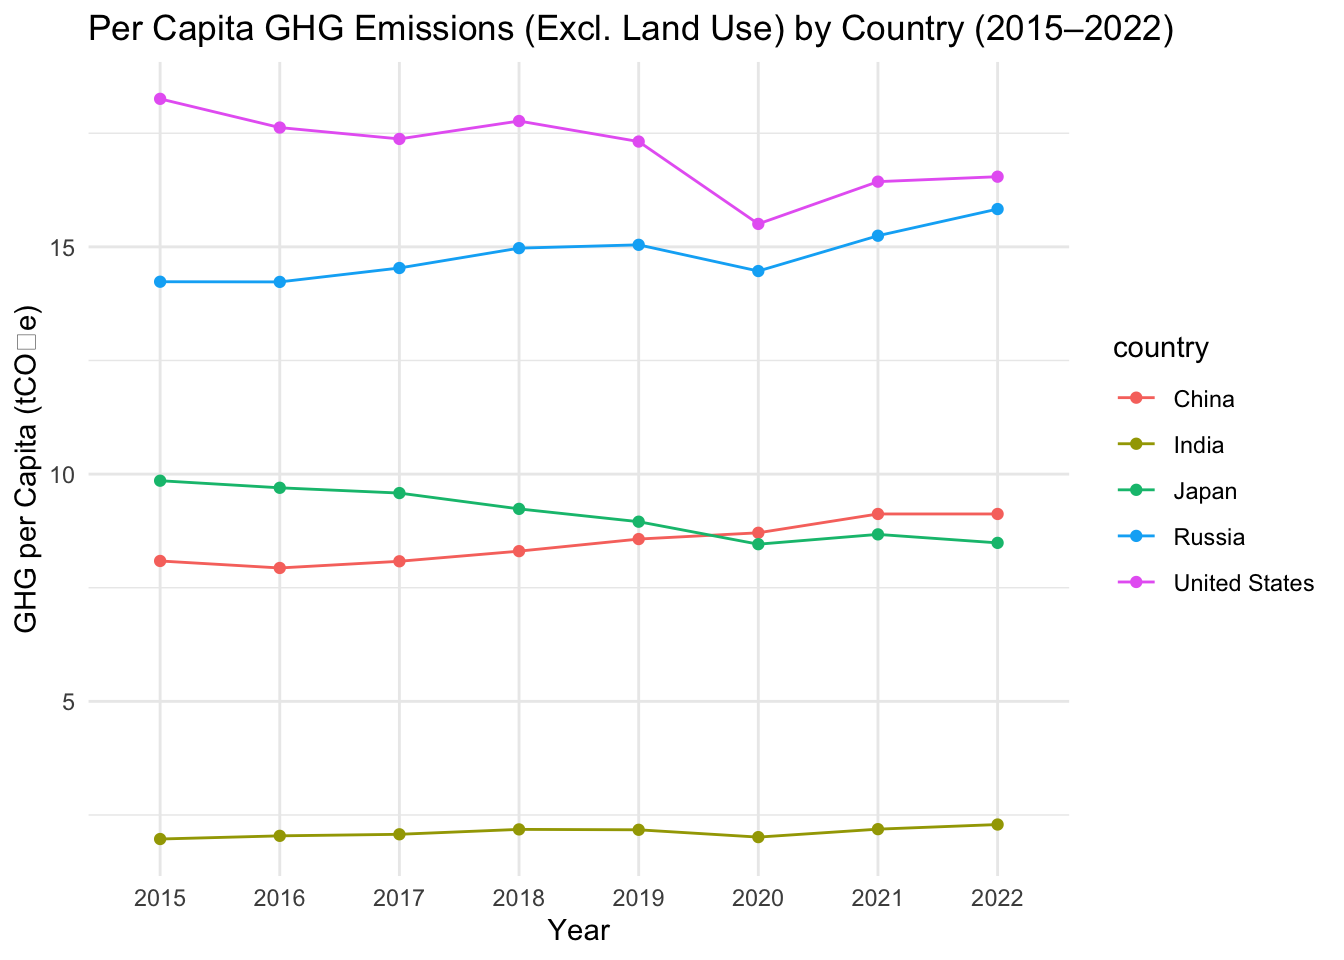

In [ ]:
ggplot(df, aes(x = factor(year), y = ghg_excluding_lucf_per_capita, color = country, group = country)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Per Capita GHG Emissions (Excl. Land Use) by Country (2015–2022)",
    x = "Year", y = "GHG per Capita (tCO₂e)"
  ) +
  theme_minimal()

Thise graph shows how greenhouse gas emissions per person changed in China, the United States, India, Russia, and Japan from 2015 to 2022. You can see a drop around 2020 during COVID, especially in the United States and Russia. Some countries’ emissions started going back up after 2020.

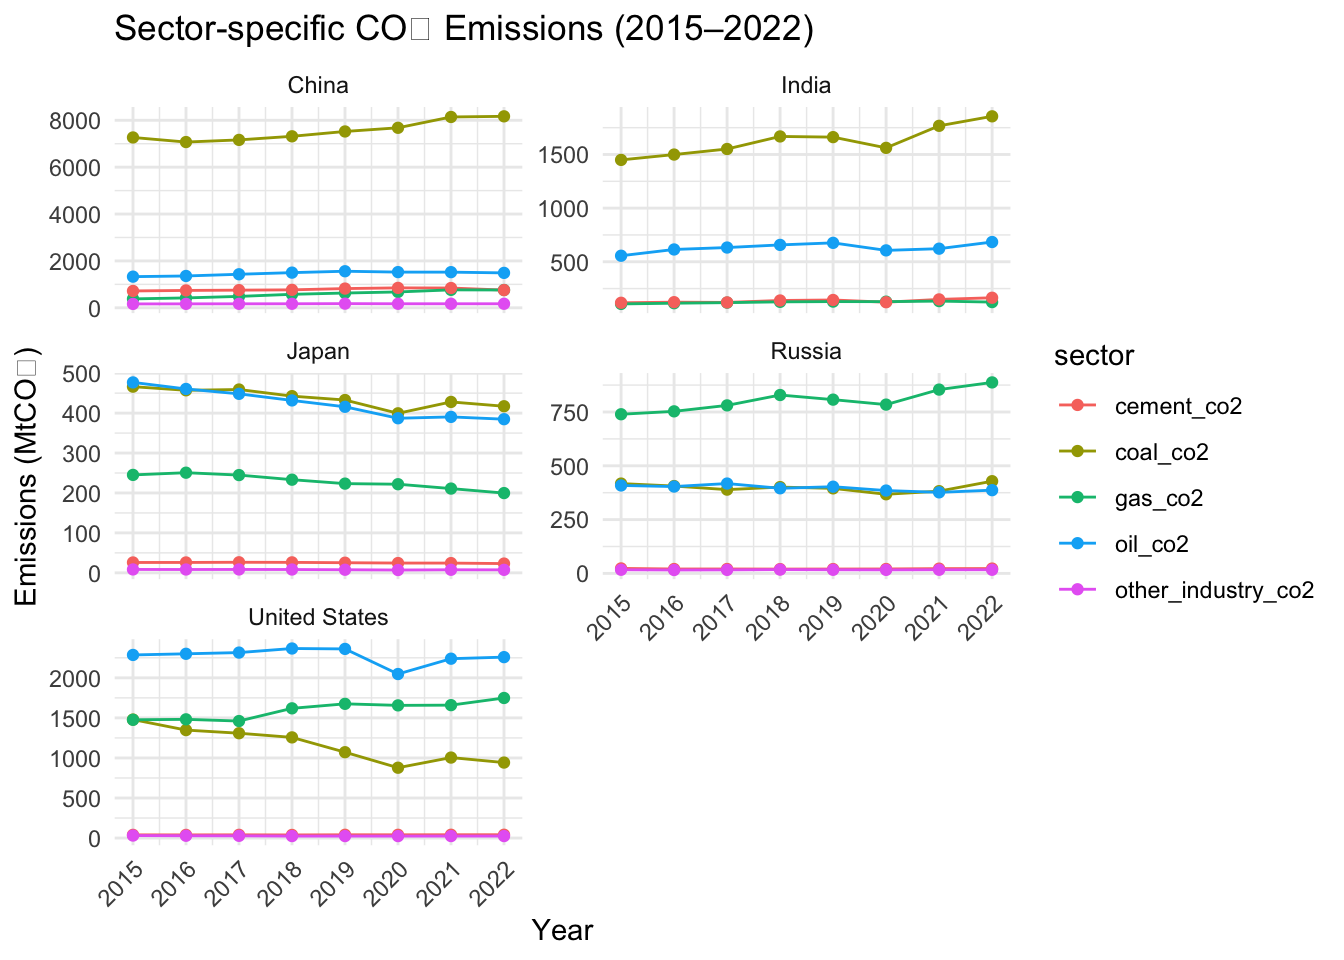

In [ ]:
# Pivot longer and remove missing emissions
df_long <- df |> 
  pivot_longer(cols = c(coal_co2, gas_co2, oil_co2, cement_co2, other_industry_co2),
               names_to = "sector", values_to = "emissions") |> 
  drop_na(emissions)

# Plot
ggplot(df_long, aes(x = year, y = emissions, color = sector, group = interaction(sector, country))) +
  geom_line() +
  geom_point() +
  facet_wrap(~ country, scales = "free_y", ncol = 2) +  # Make panels wider
  scale_x_continuous(breaks = 2015:2022) +              # Show all years
  labs(title = "Sector-specific CO₂ Emissions (2015–2022)", 
       x = "Year", 
       y = "Emissions (MtCO₂)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate year labels

This graph shows where each country’s emissions came from — like coal, oil, gas, cement, or other industries. For example, China has a lot of coal emissions, and the United States has more oil emissions. You can also see how emissions from some sectors dropped in 2020 and then changed again after COVID.

### Statistical Analyses

-   ANOVA: Tested whether there were significant differences in per capita GHG emissions across the three periods (pre-, during-, post-COVID) for each country.

-   Linear Regression: Modeled per capita GHG emissions (ghg_excluding_lucf_per_capita) as a function of sector-specific CO₂ emissions (coal_co2, oil_co2, gas_co2, cement_co2, other_industry_co2).


--- ANOVA for China ---
            Df Sum Sq Mean Sq F value Pr(>F)  
period       2 1.2803  0.6402   13.06 0.0103 *
Residuals    5 0.2451  0.0490                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--- ANOVA for India ---
            Df  Sum Sq  Mean Sq F value Pr(>F)
period       2 0.04456 0.022280   2.956  0.142
Residuals    5 0.03769 0.007537               

--- ANOVA for Japan ---
            Df Sum Sq Mean Sq F value Pr(>F)  
period       2 1.6155  0.8077   7.299 0.0329 *
Residuals    5 0.5533  0.1107                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--- ANOVA for Russia ---
            Df Sum Sq Mean Sq F value Pr(>F)  
period       2 1.3923  0.6961   4.433 0.0781 .
Residuals    5 0.7852  0.1570                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--- ANOVA for United States ---
            Df Sum Sq Mean Sq F value  Pr(>F)   
period       2  4.906  2.4529   21.37 0.00355 **
Res

`geom_smooth()` using formula = 'y ~ x'

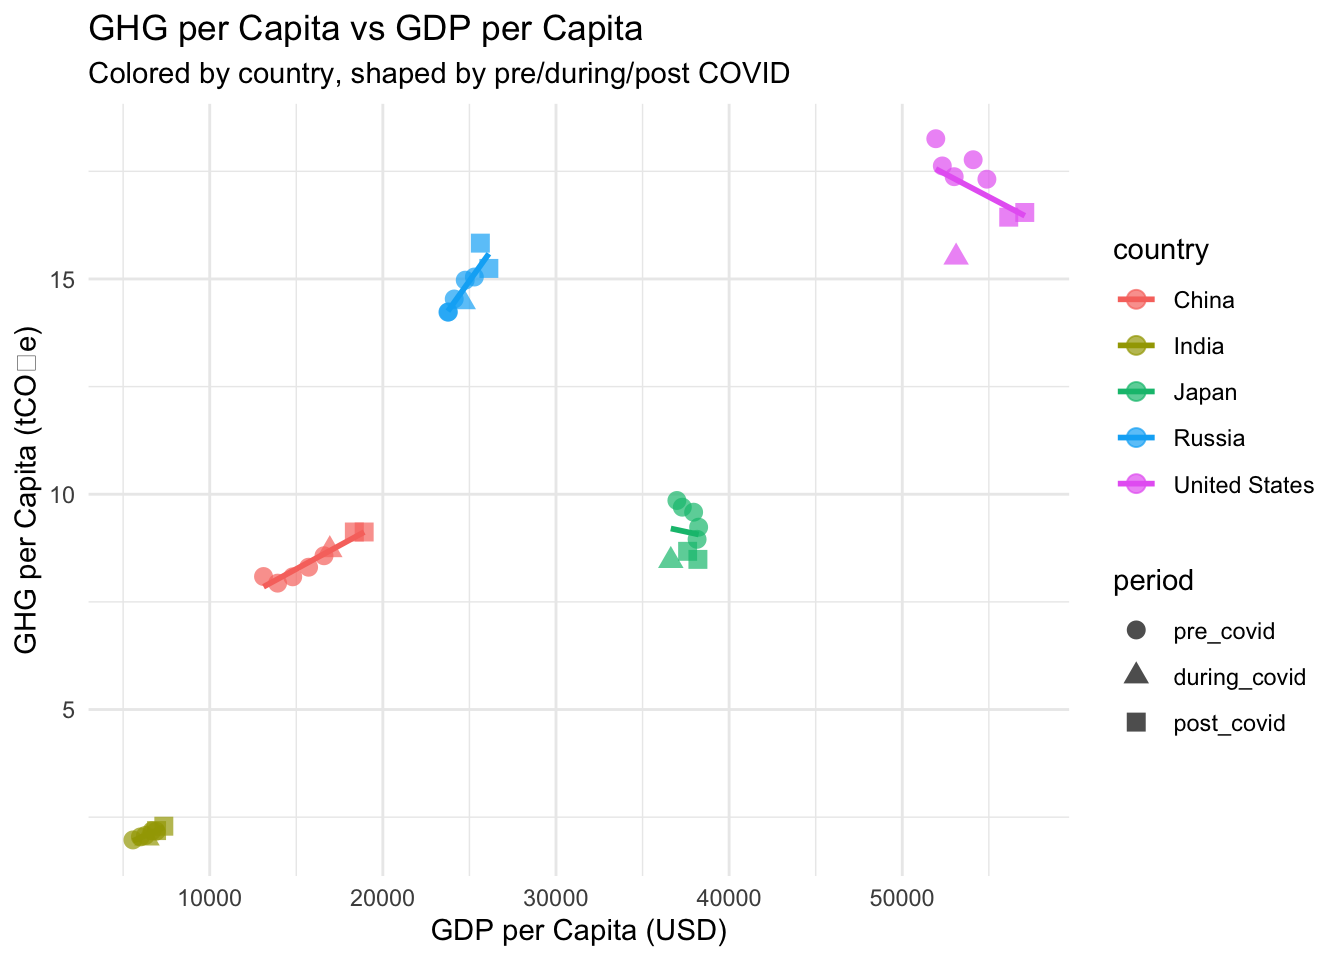

In [ ]:
# 1. Prepare data
df <- data_filtered |>
  filter(country %in% top_emitters) |>
  select(country, year, ghg_excluding_lucf_per_capita,
         coal_co2, gas_co2, oil_co2, cement_co2, other_industry_co2,
         gdp, population) |>
  mutate(
    gdp_per_capita = gdp / population,
    period = case_when(
      year <= 2019 ~ "pre_covid",
      year == 2020 ~ "during_covid",
      year >= 2021 ~ "post_covid"
    )
  ) |>
  mutate(period = factor(period, levels = c("pre_covid", "during_covid", "post_covid")))

# 2. Run ANOVA for each country
for (c in unique(df$country)) {
  df_country <- df |> filter(country == c)
  if (n_distinct(df_country$period) > 1) {
    cat("\n--- ANOVA for", c, "---\n")
    model <- aov(ghg_excluding_lucf_per_capita ~ period, data = df_country)
    print(summary(model))
  } else {
    cat("\n--- Skipped ANOVA for", c, ": not enough periods ---\n")
  }
}

| Country       | p-value | Interpretation                    |
|:--------------|:--------|:----------------------------------|
| China         | 0.0103  | Significant change (p \< 0.05)    |
| India         | 0.142   | No significant change (p \> 0.05) |
| Japan         | 0.0329  | Significant change (p \< 0.05)    |
| Russia        | 0.0781  | Not quite significant (p \> 0.05) |
| United States | 0.00355 | Significant change (p \< 0.01)    |

In [ ]:
lm_model <- lm(ghg_excluding_lucf_per_capita ~ coal_co2 + oil_co2 + gas_co2 + cement_co2 + other_industry_co2, data = df)
summary(lm_model)


Call:
lm(formula = ghg_excluding_lucf_per_capita ~ coal_co2 + oil_co2 + 
    gas_co2 + cement_co2 + other_industry_co2, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2833 -0.3541  0.1507  0.4693  1.4989 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         8.2798981  0.3661956  22.611  < 2e-16 ***
coal_co2            0.0003590  0.0008477   0.424 0.675372    
oil_co2            -0.0021149  0.0005530  -3.825 0.000737 ***
gas_co2             0.0074705  0.0008038   9.293 9.53e-10 ***
cement_co2         -0.0237091  0.0076398  -3.103 0.004572 ** 
other_industry_co2  0.0864354  0.0379252   2.279 0.031111 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9042 on 26 degrees of freedom
  (8 observations deleted due to missingness)
Multiple R-squared:  0.9521,    Adjusted R-squared:  0.9429 
F-statistic: 103.3 on 5 and 26 DF,  p-value: 2.663e-16

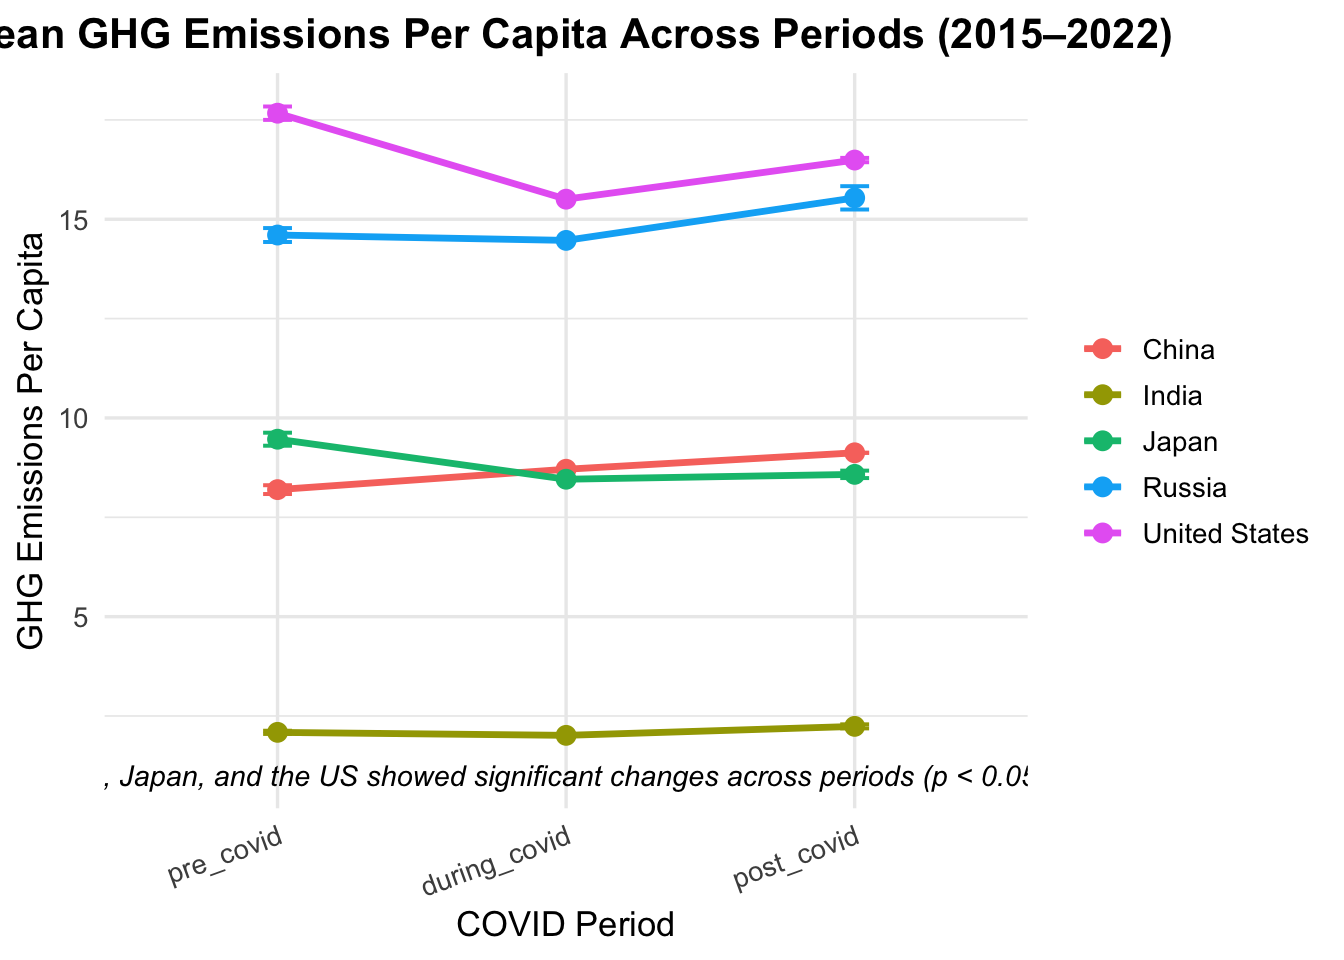

In [ ]:
library(dplyr)
library(ggplot2)

# Example summary dataframe (replace with your actual grouped summary if needed)
summary_df <- df %>%
  group_by(country, period) %>%
  summarize(
    mean_emission = mean(ghg_excluding_lucf_per_capita, na.rm = TRUE),
    se = sd(ghg_excluding_lucf_per_capita, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  )

# Optional: Set factor order for periods
summary_df$period <- factor(summary_df$period, levels = c("pre_covid", "during_covid", "post_covid"))

# Plot
ggplot(summary_df, aes(x = period, y = mean_emission, group = country, color = country)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = mean_emission - se, ymax = mean_emission + se), width = 0.1, linewidth = 0.7) +
  labs(
    title = "Mean GHG Emissions Per Capita Across Periods (2015–2022)",
    x = "COVID Period",
    y = "GHG Emissions Per Capita"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 20, hjust = 1),
    legend.title = element_blank()
  ) +
  annotate("text", x = 2, y = min(summary_df$mean_emission) - 1,
           label = "Only China, Japan, and the US showed significant changes across periods (p < 0.05, ANOVA).",
           size = 3.8, hjust = 0.5, fontface = "italic")

#### Model Validation

-   Plotted actual vs. predicted emissions to assess model fit.

-   Visualized regression coefficients with confidence intervals to interpret the influence of each emission sector.

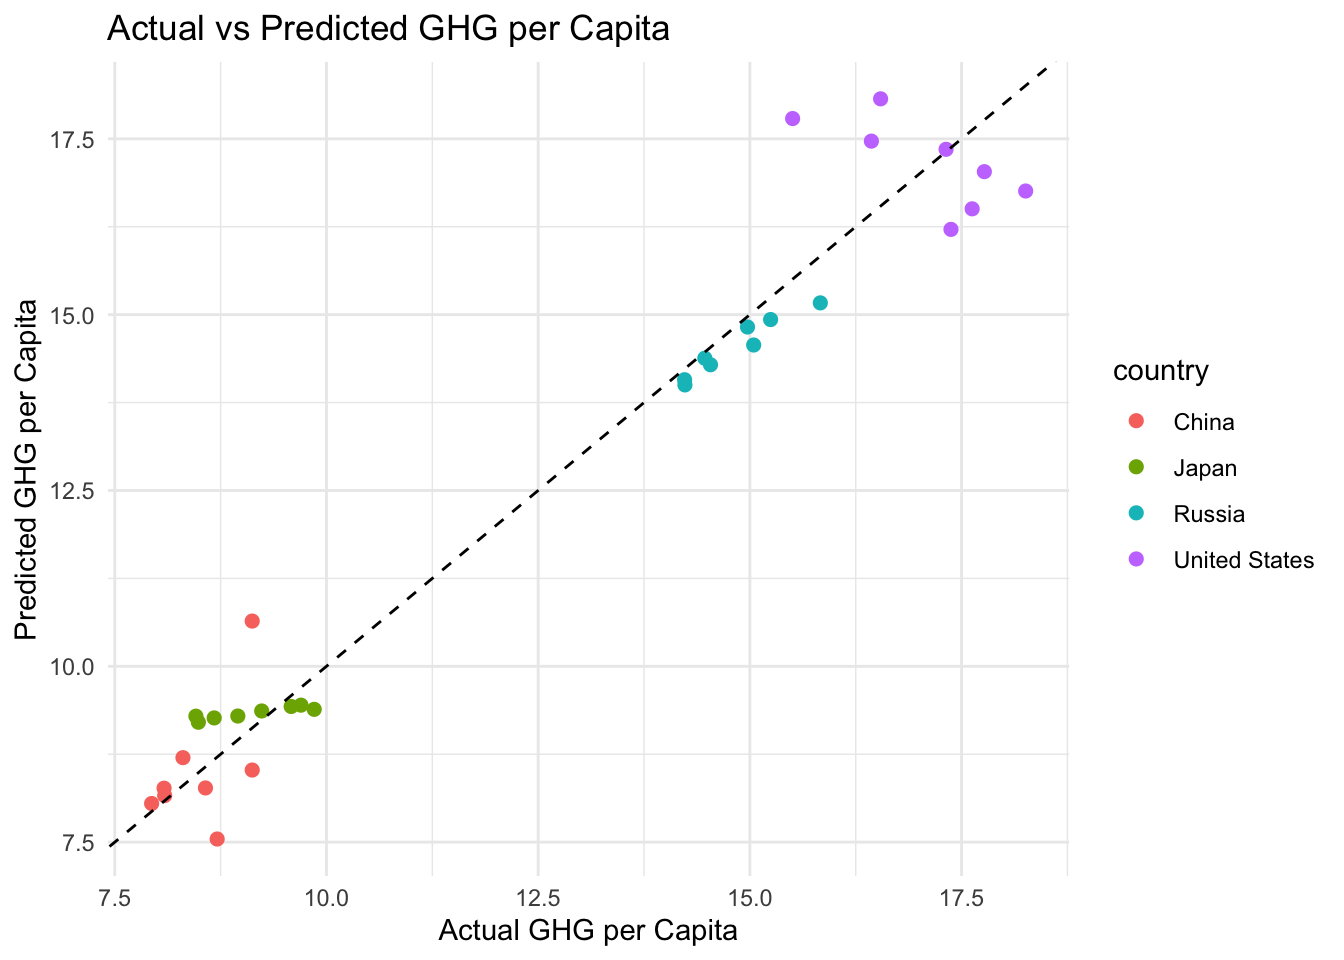

In [ ]:
# After selecting the variables, clean properly:
df <- df |> drop_na(ghg_excluding_lucf_per_capita, coal_co2, oil_co2, gas_co2, cement_co2, other_industry_co2)

# Now build the model
lm_model <- lm(ghg_excluding_lucf_per_capita ~ coal_co2 + oil_co2 + gas_co2 + cement_co2 + other_industry_co2, data = df)

# Now add predictions
df$predicted <- predict(lm_model)

# Now plot Actual vs Predicted
ggplot(df, aes(x = ghg_excluding_lucf_per_capita, y = predicted, color = country)) +
  geom_point(size = 2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(title = "Actual vs Predicted GHG per Capita",
       x = "Actual GHG per Capita",
       y = "Predicted GHG per Capita") +
  theme_minimal()

This graph compares the real emissions to the ones predicted by our model. If the points are close to the dashed line, it means the model did a good job. Most of the points are pretty close to the line, so the model worked well.

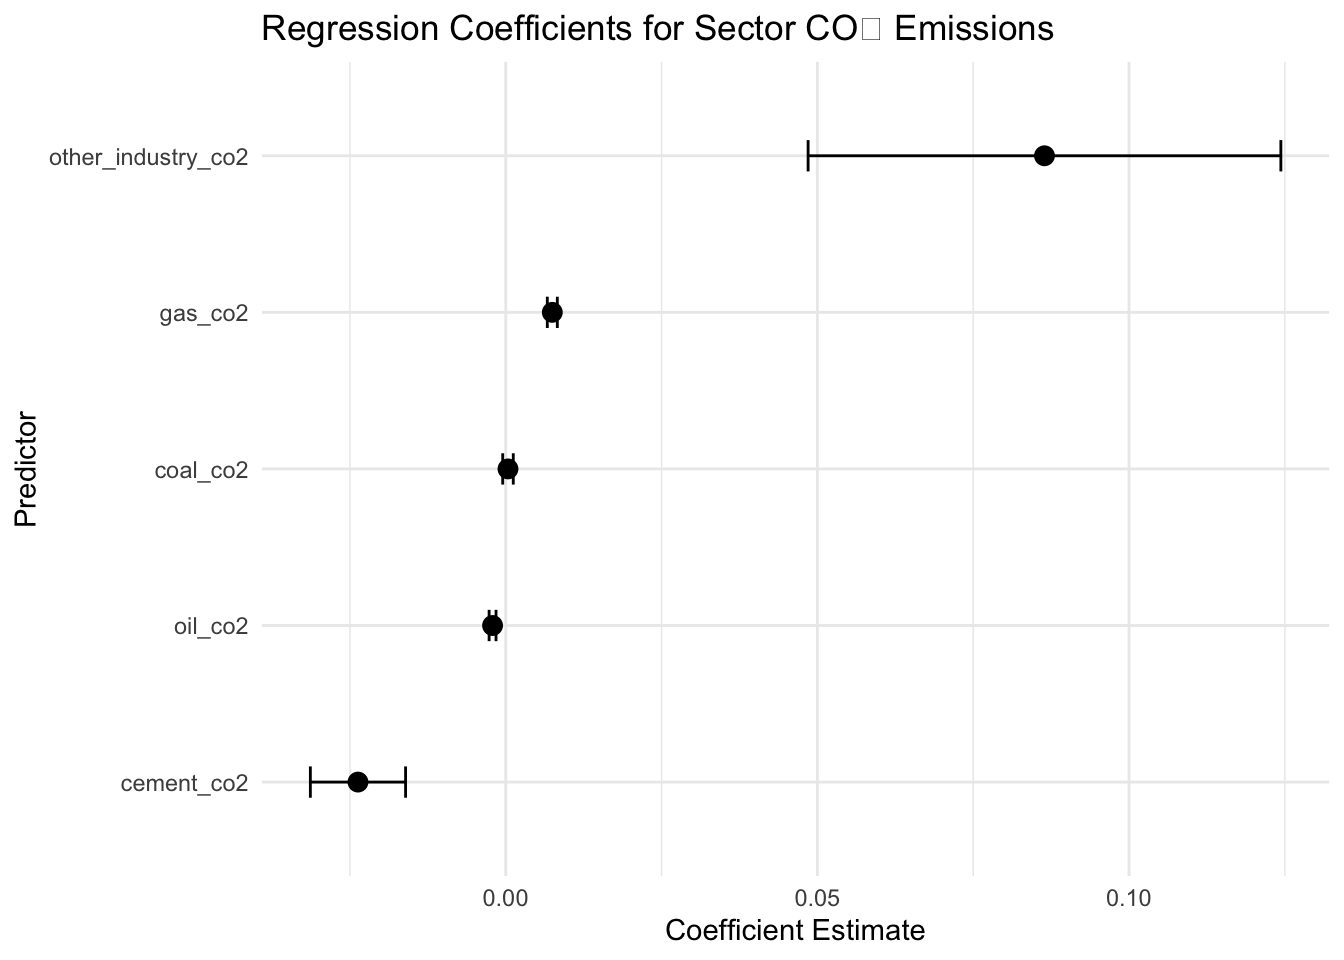

In [ ]:
library(broom)

tidy_lm <- broom::tidy(lm_model)

ggplot(tidy_lm[-1, ], aes(x = estimate, y = reorder(term, estimate))) + 
  geom_point(size = 3) +
  geom_errorbarh(aes(xmin = estimate - std.error, xmax = estimate + std.error), height = 0.2) +
  labs(title = "Regression Coefficients for Sector CO₂ Emissions",
       x = "Coefficient Estimate",
       y = "Predictor") +
  theme_minimal()

This figure showes regression coefficients showing the relationship between sector-specific CO₂ emissions and per capita GHG emissions. Gas emissions were the strongest positive predictor, while oil and cement emissions were negatively associated with per capita emissions. Error bars represent standard errors.

## CO2 per Unit Energy Modeling

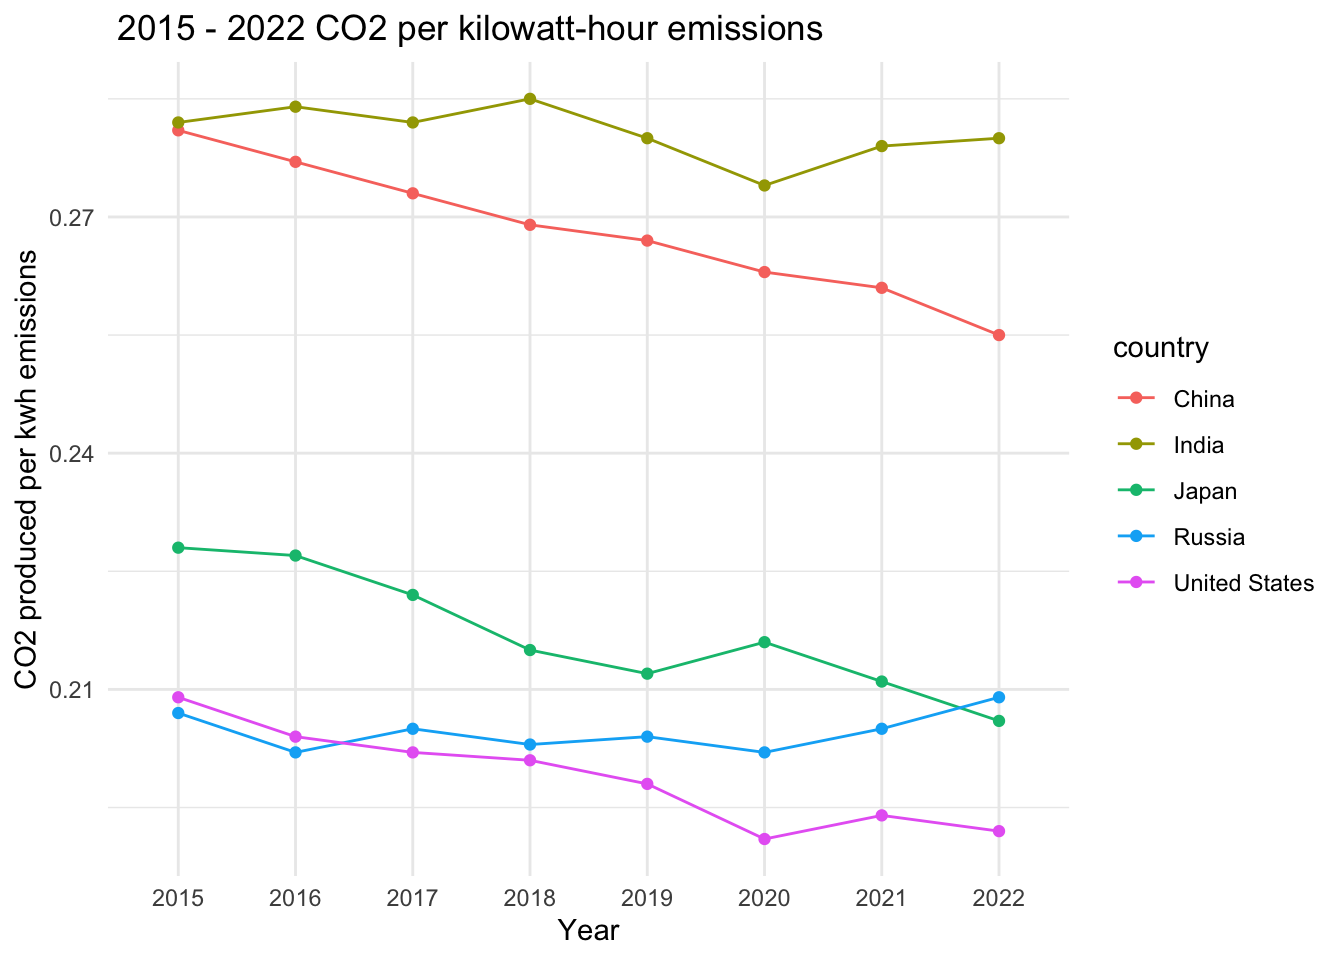

In [ ]:
#co2_per_unit_energy
 
df3 <- data_filtered %>% 
  group_by(country) %>% 
  filter(country %in% c("China", "India", "Russia", "United States", "Japan")) %>%
  select(country, year, co2_per_unit_energy,
         ghg_excluding_lucf_per_capita) %>% 
  mutate(percap = ghg_excluding_lucf_per_capita, energy = co2_per_unit_energy)


ggplot(df3, aes(x = factor(year), y = co2_per_unit_energy, color = country, group = country)) +
  geom_line() +
  geom_point() +
  labs(
    title = " 2015 - 2022 CO2 per kilowatt-hour emissions",,
    x = "Year", y = "CO2 produced per kwh emissions"
  ) +
  theme_minimal()

**Figure 2.** CO2 per kilowatt-hour emissions for the top five cumulative emitters.

**Proportion of CO2 emitted by the five selected countries** In 2022, India and Russia’s CO2 emissions per kilowatt-hour have risen, while China, the United States, and Japan’s emissions have decreased. (Figure 2.) The top five biggest co2 emitted of the world emitted a total of 27168.36 million metric tons of greenhouse gases in 2022. That year, the other 213 countries emitted metric tons of greenhouse gasses, meaning 50.97 percent of greenhouse gas emissions come from the top 5 most polluting countries. The mean emissions per capita in the top 5 biggest greenhouse gas emitters was 10.45 CO2 equivalents versus a mean of only 5.59 CO2 equivalents for the rest of the countries.

In [ ]:
#shapiro test for Public restrictions
normspub2 <- df3 |> 
  nest(data = -country) |>
  mutate(
    Shapiro = map(data, ~ shapiro.test(na.omit(.x$energy))),  # Remove NAs before applying shapiro.test
    n = map_dbl(data, nrow),
    glance_shapiro = map(Shapiro, broom::glance)
  ) |>
  unnest(glance_shapiro)

flextable::flextable(dplyr::select(normspub2, country, n, statistic, p.value)) |>
  flextable::set_caption("Shapiro-Wilk normality test for energy consumption in each country")

country,n,statistic,p.value
China,8,0.9880975,0.9915808
India,8,0.9287910,0.5051372
Japan,8,0.9407402,0.6183777
Russia,8,0.9249849,0.4716001
United States,8,0.9545535,0.7569171


ANOVA for co2 emissions per unit energy

`bins`.

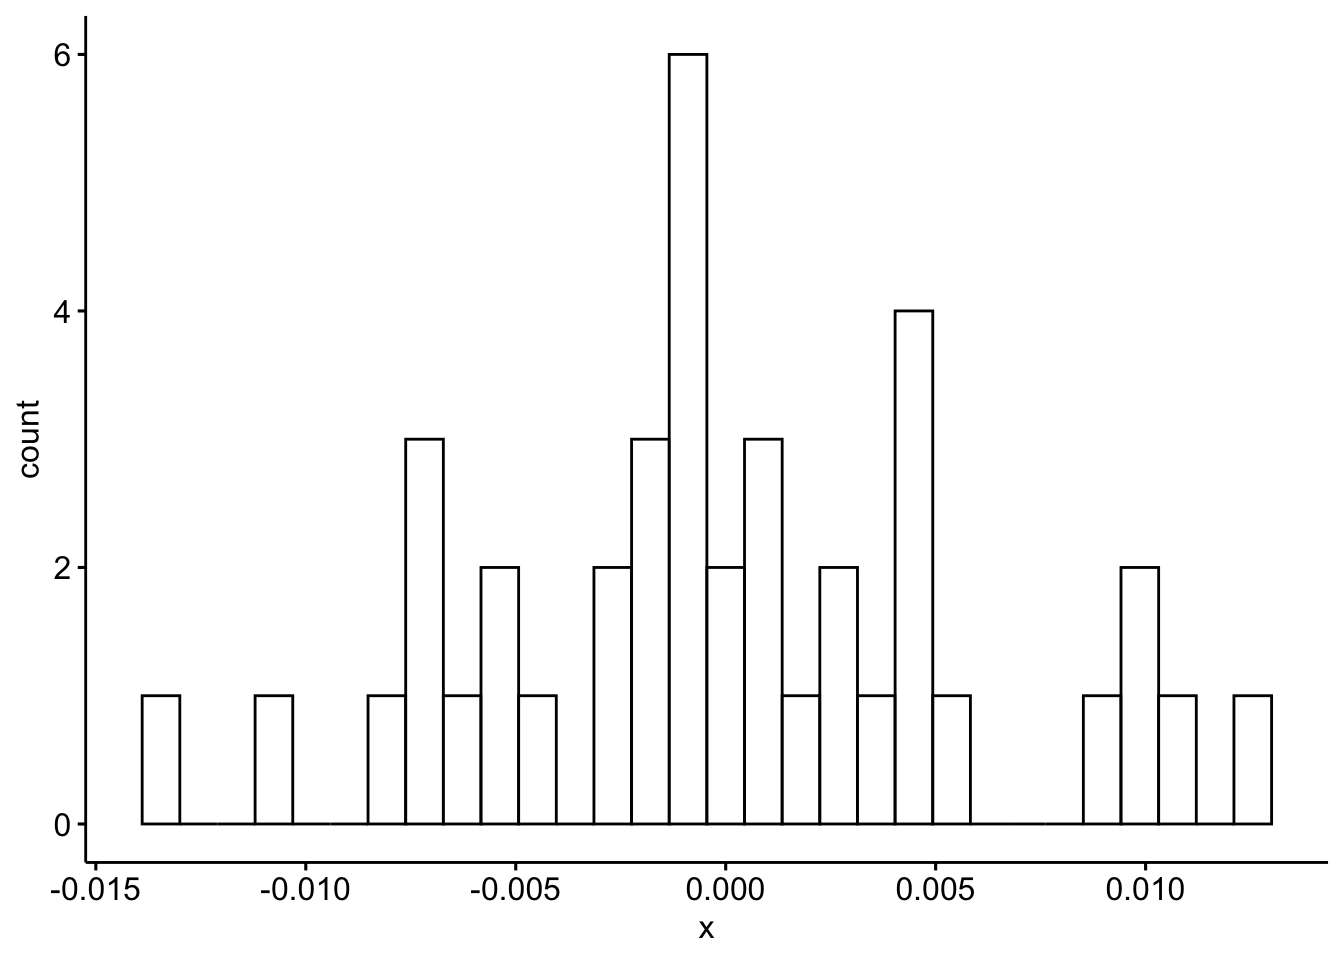


    Shapiro-Wilk normality test

data:  res_aov$residuals
W = 0.98372, p-value = 0.8234

In [ ]:
library(ggpubr)

res_aov <- aov(formula = co2_per_unit_energy ~ country, data = df3)

#making sure residuals have a normal distribution
gghistogram(res_aov$residuals)

`bins`.

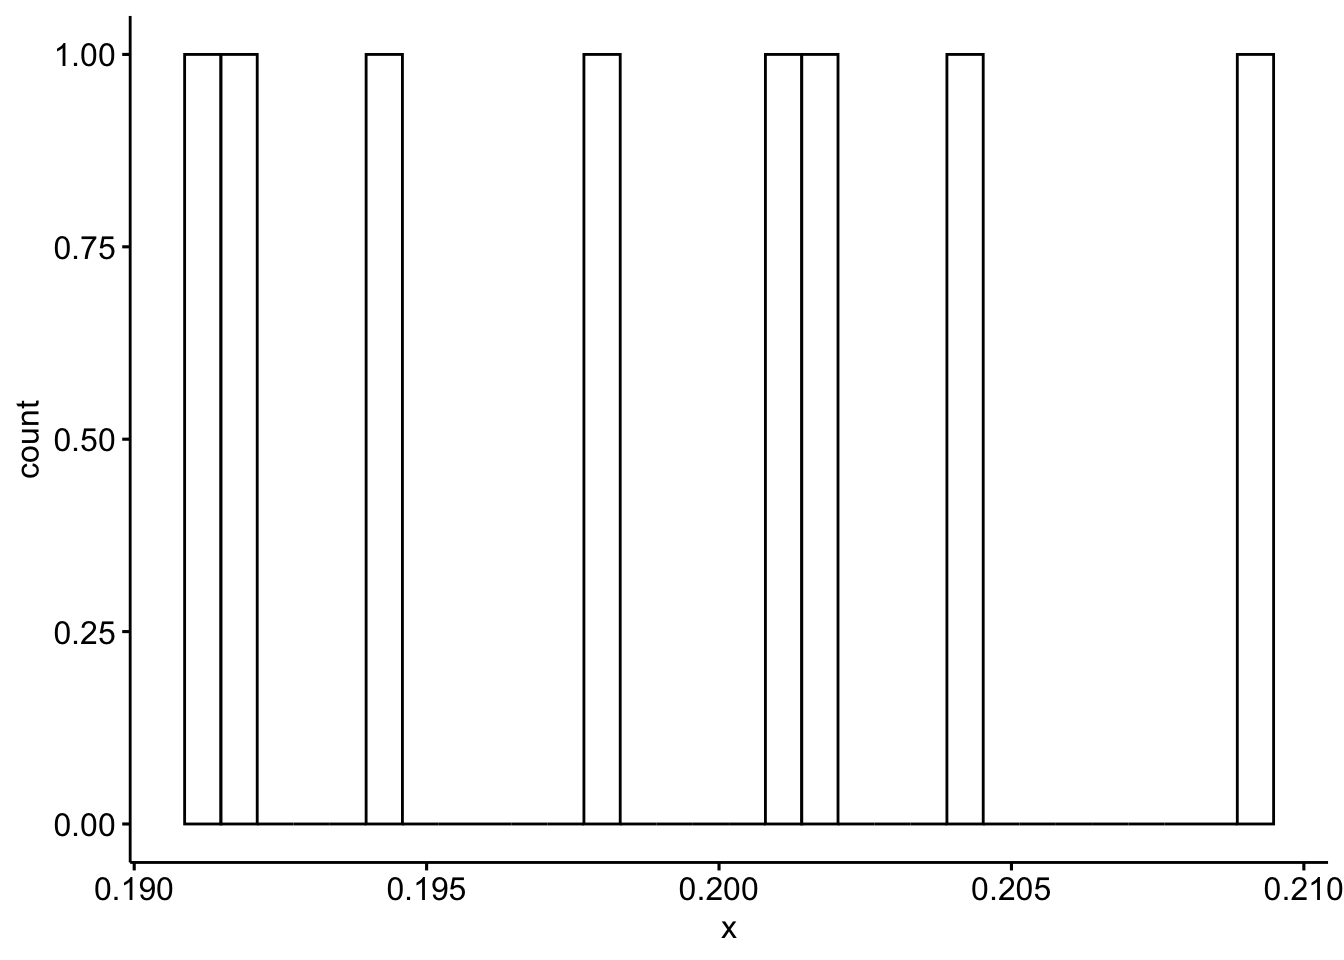


    Shapiro-Wilk normality test

data:  df3$energy
W = 0.8199, p-value = 1.81e-05

In [ ]:
library(ggpubr)
norm_usa <- df3 %>% group_by(country) %>% 
filter(country == "United States")

gghistogram(norm_usa$energy)

p-values from ANOVA

**Table 2.** Summary statistics of an ANOVA analysis of CO2 emitted per kilowatt-hour for the top 5 cumulative CO2 emitters.

In [ ]:
summary(aov(formula = co2_per_unit_energy ~ country, data = df3))

            Df  Sum Sq  Mean Sq F value Pr(>F)    
country      4 0.04592 0.011480   297.1 <2e-16 ***
Residuals   35 0.00135 0.000039                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

**Difference in CO2 per kilowatt-hour emissions between countries** There is a statistically significant difference (p \< 0.000) in CO2 per kilowatt-hour for the top 5 biggest cumulative CO2 emitters (Table 2).

## Predicting CO2 Emissions per unit Energy

Mutate data, check for Interaction terms

In [ ]:
#set a seed
set.seed(341)

#doing a correlation test for variables
1

[1] 1

None of the variables had strong enough correlations to make interaction terms.

## making testing and training data for energy consumption

In [ ]:
#find recipe format from lab 6 / model daily assignments
library(rsample)

ghg_per_eny_split <- initial_split(ghg_per_eny, prop = .8)
ghg_per_eny_train <- training(ghg_per_eny_split)
ghg_per_eny_test  <- testing(ghg_per_eny_split)


ghg_per_eny_cv <- vfold_cv(ghg_per_eny, v = 10)

In [ ]:
#attempted recipe format
library(recipes)


Attaching package: 'recipes'

The following object is masked from 'package:stringr':

    fixed

The following object is masked from 'package:stats':

    step

Making different models to test against

In [ ]:
#making the models
library(parsnip)

boost <- boost_tree() %>%
  # define the engine
  set_engine("xgboost") %>%
  # define the mode
  set_mode("regression")

nnet <- bag_mlp() %>%
  # define the engine
  set_engine("nnet") %>%
  # define the mode
  set_mode("regression")

dtree <- decision_tree() %>%
  # define the engine
  set_engine("rpart") %>%
  # define the mode
  set_mode("regression")

rf <- rand_forest(
  mtry = 5,
  trees = 1000,
  min_n = 5
) %>%
  set_engine("ranger", importance = "impurity") %>% 
  set_mode("regression")

Plotting the best predictive models of emissions per unit energy

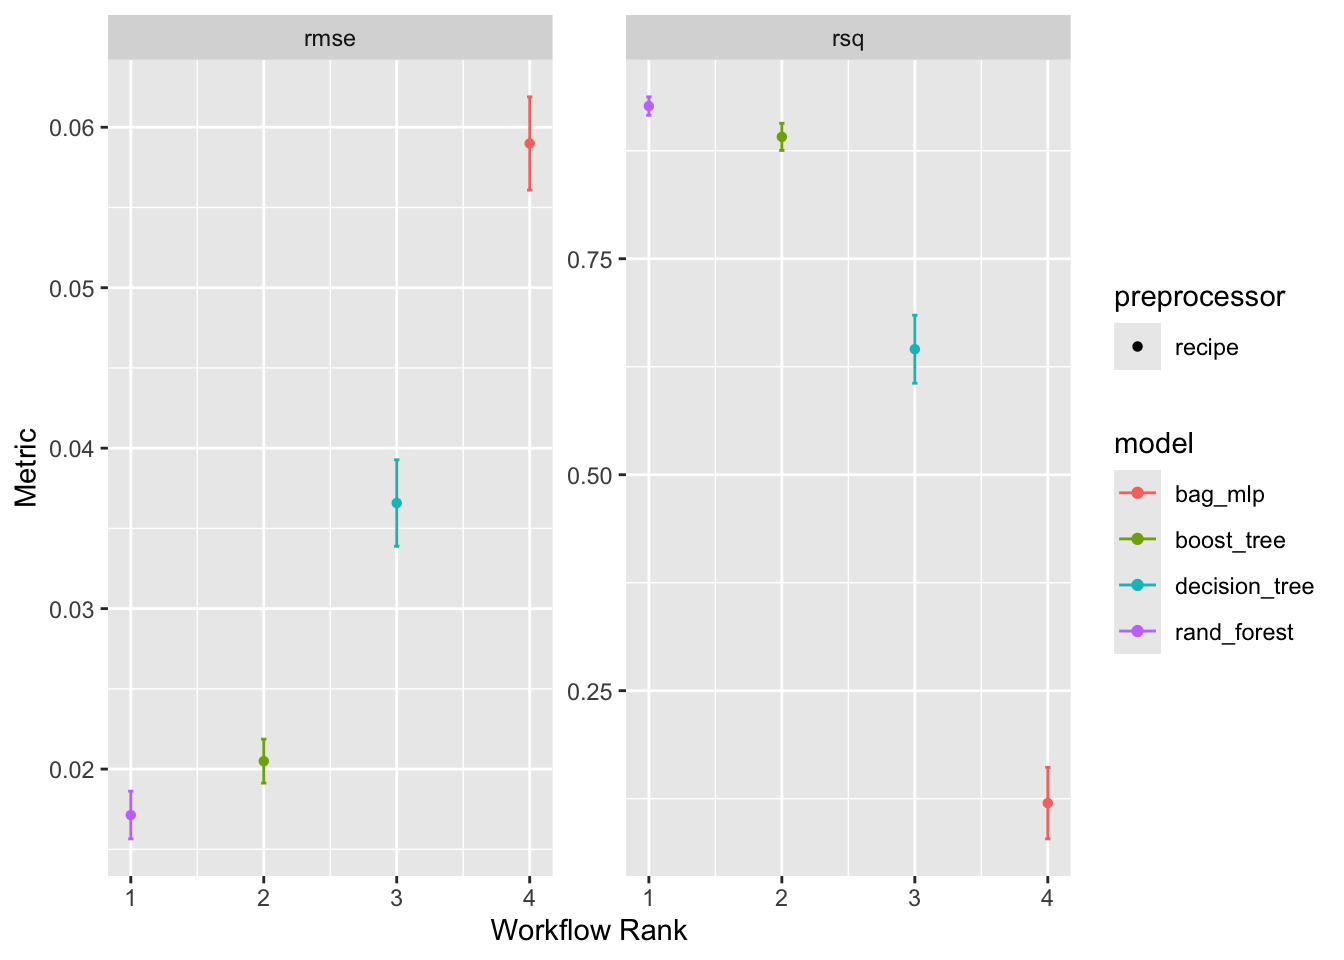

In [ ]:
library(workflowsets)
library(baguette)
library(ranger)

wf <-  workflow_set(list(rec_energy), 
                  list(boost,
                       nnet,
                       dtree,
                       rf)) %>%
  workflow_map('fit_resamples', resamples = ghg_per_eny_cv) 


autoplot(wf)

**Figure 4.** Ranking different models’ root mean squared error and R-squared error values, tested against CO2 per kilowatt hour emissions data for the top five cumulative CO2 emitters.

Results:

The graph shows that random forest is the best model for predicting carbon emissions per unit energy.

**Table 3.** Ranking Model Testing Results

In [ ]:
rank_results(wf, rank_metric = "rsq", select_best = TRUE)

# A tibble: 8 × 9
  wflow_id         .config .metric   mean std_err     n preprocessor model  rank
  <chr>            <chr>   <chr>    <dbl>   <dbl> <int> <chr>        <chr> <int>
1 recipe_rand_for… Prepro… rmse    0.0171 9.04e-4    10 recipe       rand…     1
2 recipe_rand_for… Prepro… rsq     0.927  6.51e-3    10 recipe       rand…     1
3 recipe_boost_tr… Prepro… rmse    0.0205 8.33e-4    10 recipe       boos…     2
4 recipe_boost_tr… Prepro… rsq     0.891  9.56e-3    10 recipe       boos…     2
5 recipe_decision… Prepro… rmse    0.0366 1.64e-3    10 recipe       deci…     3
6 recipe_decision… Prepro… rsq     0.645  2.40e-2    10 recipe       deci…     3
7 recipe_bag_mlp   Prepro… rmse    0.0590 1.77e-3    10 recipe       bag_…     4
8 recipe_bag_mlp   Prepro… rsq     0.120  2.52e-2    10 recipe       bag_…     4

The random forest does best in this situation to model ghg emissions per unit energy

### Making a workflow to predict ghg emitted per kilowatt-hour

In [ ]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ dials     1.4.0     ✔ tune      1.3.0
✔ infer     1.0.8     ✔ workflows 1.2.0
✔ modeldata 1.4.0     ✔ yardstick 1.3.2

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ dials::prune()    masks rpart::prune()
✖ xgboost::slice()  masks dplyr::slice()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()

[1] 158   9

finding the most statistically significant predictors

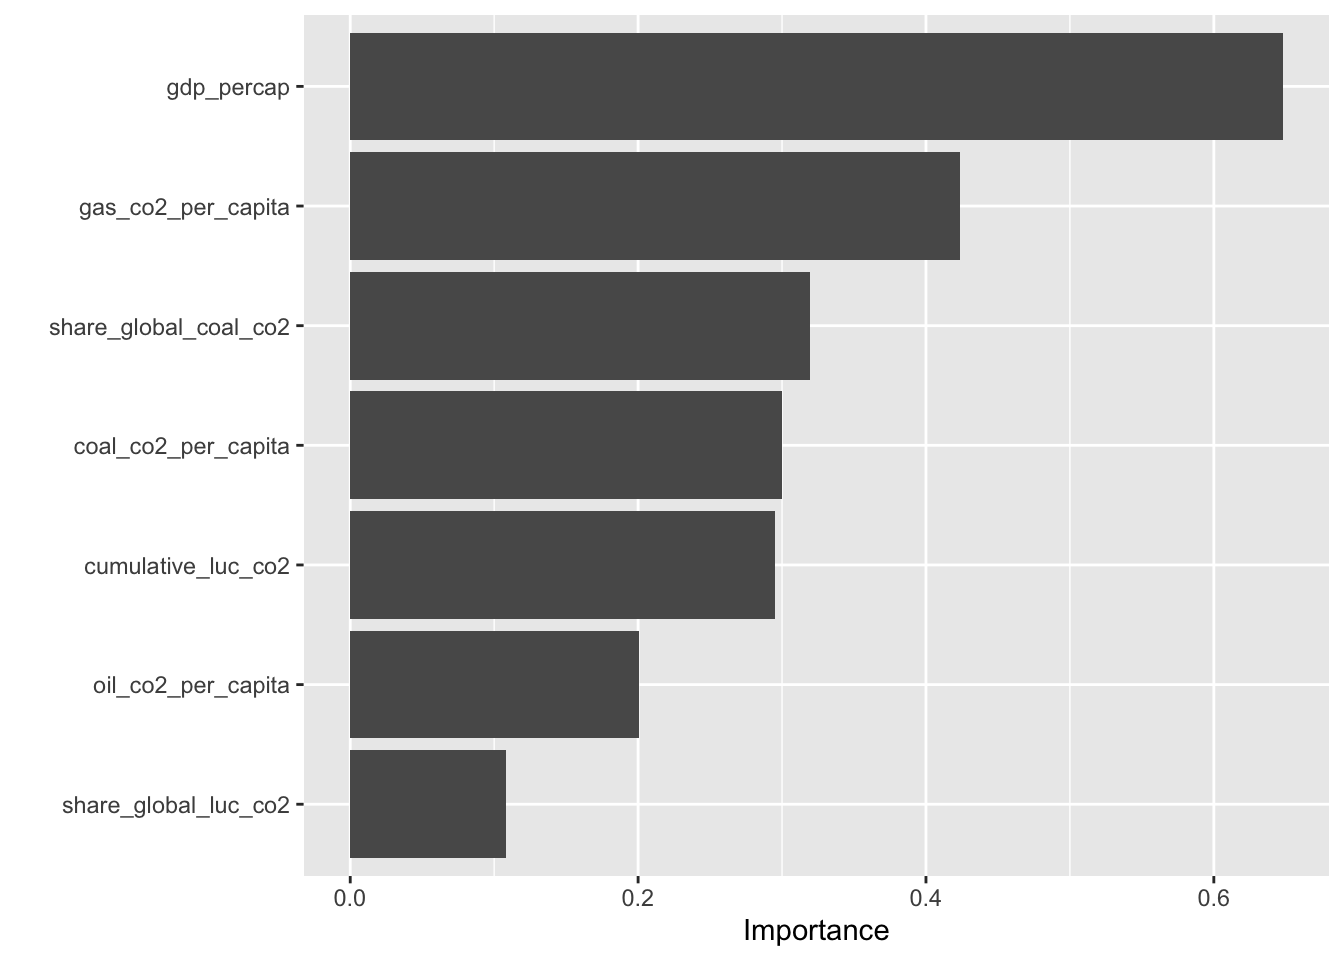

In [ ]:
rf_model <- extract_fit_engine(rf_wf)
vip::vip(rf_model)

**Figure 5.** Ranking importance of each predictor variable at explaining CO2 emissions per kilowatt-hour in the random forest model selected for analysis.

**Predictor variables for CO2 per kilowatt-hour** The graph shows that random forest is the best model for predicting carbon emissions per unit energy, with an R-squared of 0.91. (Figure 4). The most explanatory variable for predicting CO2 emissions per unit of energy consumption during the the 2015 to 2022 period in the five countries examined was GDP per capita followed by CO2 emitted from gas per capita (Figure 5).

Forster, P. M., Forster, H. I., Evans, M. J., Gidden, M. J., Jones, C. D., Keller, C. A., Lamboll, R. D., Le Quéré, C., Rogelj, J., Rosen, D., et al. (2020). Current and future global climate impacts resulting from COVID-19. *Nature Climate Change*, *10*(10), 913–919.

Friedlingstein, P., Jones, M. W., O’Sullivan, M., Andrew, R. M., Hauck, J., Peters, G. P., Peters, W., Pongratz, J., Sitch, S., Le Quéré, C., et al. (2019). Global carbon budget 2019. *Earth System Science Data*, *11*(4), 1783–1838.

Samborska, V. (2025). Scaling up: How increasing inputs has made artificial intelligence more capable. *Our World in Data*.